# StarEightyTwo + Mapping Prejudice: An Inter-rater Reliability Project

In [ ]:
import os
os.chdir('/Users/jake/Documents/stareightytwo/projects/mapping_prejudice/mapping_prejudice/Intermediate')

from collections import Counter
from itertools import combinations
import json

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
sns.set()

import pandas as pd
import numpy as np
from sklearn.metrics import jaccard_similarity_score, cohen_kappa_score

def handle_zero_division(x, y):
    try:
        return x/y
    except ZeroDivisionError:
        return None

In [357]:
df = pd.read_csv('placeholder_10_8_2017.csv')

df.replace({'null': np.nan}, inplace=True)

# Some users for some reason have seen images but didn't provide a classification (maybe they exited the session early?)
df = df[df['Match'].notnull()]

# Username obfuscation key-value mapping... don't necessarily need to use this right now, but will need to
# before exposing to others
df['User_Name_orig'] = df['User_Name']

if True:
    # Create the mapping... this should only be done once
    username_mapping = {name: 'user_{}'.format(i) for i, name in enumerate(set(df['User_Name'].dropna()))}
    
    # Save it
    with open('usernames_remapped.json', 'w') as f:
        json.dump(username_mapping, f)
else:
    # Load an existing mapping
    with open('usernames_remapped.json', 'r') as f:
        username_mapping = json.load(f)
    
df['User_Name'] = df['User_Name'].map(username_mapping)

### Classifications over time
Below, we can see a significant spike in classifications after the most recent Star Tribune article highlighting Mapping Prejudice's work.

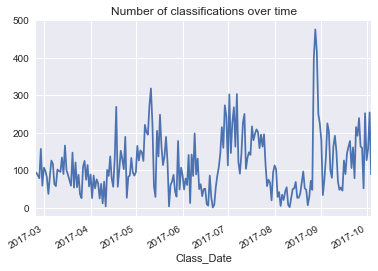

In [358]:
df['Class_Date'] = pd.to_datetime(pd.to_datetime(df['Class_Date']).astype(str).str.split().str[0])

df.groupby(['Class_Date']).size().plot(title='Number of classifications over time')

plt.show()

### How about the number of classifications by user?

In [359]:
gb = df.groupby('User_Name').size().sort_values(ascending=False)

print(gb.head(20))

User_Name
user_222    13550
user_331     1120
user_139     1041
user_161      566
user_304      546
user_256      379
user_452      360
user_248      305
user_531      290
user_520      256
user_235      222
user_513      219
user_485      211
user_528      207
user_234      205
user_171      204
user_24       194
user_124      188
user_13       179
user_377      154
dtype: int64


Wow, there are some star citizens in this volunteer base. How many volunteers does it take to get to 80% of classifications (whether retired or not)?

In [360]:
cumu_sum = np.cumsum(gb)
pareto = cumu_sum/gb.sum()
mask = pareto <= 0.8

pareto = pd.DataFrame({'gb': gb[mask],
                       'cumu_sum': cumu_sum[cumu_sum <= 0.8*gb.sum()],
                       'cumu_perc': pareto[:gb[mask].shape[0]]})

print(pareto)
print(pareto.shape)

           cumu_perc  cumu_sum     gb
User_Name                            
user_222    0.532856     13550  13550
user_331    0.576900     14670   1120
user_139    0.617838     15711   1041
user_161    0.640096     16277    566
user_304    0.661568     16823    546
user_256    0.676472     17202    379
user_452    0.690629     17562    360
user_248    0.702623     17867    305
user_531    0.714027     18157    290
user_520    0.724095     18413    256
user_235    0.732825     18635    222
user_513    0.741437     18854    219
user_485    0.749735     19065    211
user_528    0.757875     19272    207
user_234    0.765937     19477    205
user_171    0.773959     19681    204
user_24     0.781588     19875    194
user_124    0.788981     20063    188
user_13     0.796020     20242    179
(19, 3)


It only takes 19 volunteers to cover 80% of all completed classifications. What about "retired" classifications? What's the coverage like there?

In [361]:
gb = df[df['Retired'] == 'Retired'].groupby('User_Name').size().sort_values(ascending=False)

cumu_sum = np.cumsum(gb)
pareto = cumu_sum/gb.sum()
mask = pareto <= 0.8

pareto = pd.DataFrame({'gb': gb[mask],
                       'cumu_sum': cumu_sum[cumu_sum <= 0.8*gb.sum()],
                       'cumu_perc': pareto[:gb[mask].shape[0]]})

print(pareto)
print(pareto.shape)

           cumu_perc  cumu_sum    gb
User_Name                           
user_222    0.338259      2541  2541
user_161    0.380724      2860   319
user_304    0.413072      3103   243
user_139    0.442758      3326   223
user_248    0.466853      3507   181
user_331    0.490415      3684   177
user_452    0.513578      3858   174
user_531    0.531017      3989   131
user_256    0.548456      4120   131
user_235    0.565495      4248   128
user_234    0.580937      4364   116
user_513    0.595714      4475   111
user_520    0.609957      4582   107
user_24     0.624201      4689   107
user_171    0.638445      4796   107
user_377    0.649494      4879    83
user_485    0.660410      4961    82
user_391    0.671193      5042    81
user_528    0.681709      5121    79
user_119    0.690761      5189    68
user_13     0.698482      5247    58
user_4      0.705538      5300    53
user_151    0.712460      5352    52
user_101    0.719249      5403    51
user_486    0.724973      5446    43
u

Okay, so 41 (out of 534) volunteers account for 80% of the retired classifications. That's a little better, for our purposes.

# What about overlap between classifications?
Specifically, is there enough across-rater coverage to warrant an inter-rater reliability examination?

In [362]:
overlap = {}

for user, user_df in df.groupby('User_Name'):
    overlap[user] = {}
    user_img_seen = set(user_df['Image_ID'])

    for other_user, other_df in df[df['User_Name'] != user].groupby('User_Name'):
        other_user_img_seen = set(other_df['Image_ID'])

        # Set intersection between what the user's seen and what the other user has seen
        common = user_img_seen & other_user_img_seen
        
        # Keep track of classifications in common and the number of in-common classifications (images seen)
        overlap[user][other_user] = {'common': common,
                                    'number': len(common)}

But wait! There's more (observations than we need). The approach above produces duplicates - the order in which *you and I* versus *I and you* share elements doesn't matter. We could have used `itertools.combinations`, but the following approach produces the same results:

In [363]:
# Remove duplicates... proxy for order-2 combinations
overlap_deduped = {}
for user in overlap:
    for other_user, values in overlap[user].items():
        # +1 for unordered keys
        overlap_deduped[frozenset((user, other_user))] = values
        
# Same thing!
assert len(overlap_deduped) == len(list(combinations(set(df['User_Name']), 2)))

Looking below, we can see a lot of user-other user combinations don't result in any overlap. Let's validate that every user has at least one overlap with another volunteer:

In [364]:
numbers = [overlap_deduped[fset]['number'] for fset in overlap_deduped]

sorted(Counter(numbers).most_common()[:10], key=lambda x: (-x[1], x[0]))

[(0, 139006),
 (1, 1835),
 (2, 342),
 (3, 160),
 (4, 99),
 (5, 47),
 (6, 42),
 (7, 26),
 (10, 18),
 (11, 14)]

Well, let's at least check that all users have at least *one* overlap (i.e. one common image classified) with another user.

In [365]:
# All users have at least one overlap... use the original `overlap` with duplicates for this one
anything_for_user = [1 if any(overlap[user][other_user]['number'] > 0 
                              for other_user in overlap[user]) 
                     else 0 for user in overlap]

# This shouldn't raise an exception... meaning that every user has seen at least one image that someone else has seen
assert all(x == 1 for x in anything_for_user)

Great! How about some descriptive statistics around the number of overlaps by user?

In [366]:
# Number of overlaps per user
n_overlaps_by_user = {user: sum(overlap[user][other_user]['number']
                                for other_user in overlap[user])
                      for user in overlap}

overlaps_no_dict = [n_overlaps for user, n_overlaps in n_overlaps_by_user.items()]

print('Summary statistics: number of overlaps with other users')
print('Mean: {}'.format(round(np.mean(overlaps_no_dict), 2)))
print('Median: {}'.format(np.median(overlaps_no_dict)))
print('Standard deviation: {}'.format(round(np.std(overlaps_no_dict), 2)))

Summary statistics: number of overlaps with other users
Mean: 59.35
Median: 6.0
Standard deviation: 529.32


There's definitely a lot of variation in the number of overlaps for each user. That's again due to Penny (username `pennypetersen`) -- she's a bit of a rockstar on this project. That low median isn't all that promising, though, but I suppose it's in line with the Pareto information we observed above.

Let's look more at the distribution of overlaps.

In [367]:
n_overlaps_min, n_overlaps_max = min(overlaps_no_dict), max(overlaps_no_dict)

# Number of users with at least n common classifications
users_with_at_least = {n: sum(1 for i in overlaps_no_dict if i >= n)
                           for n in set(overlaps_no_dict)}

print('Number of users with at least...')
print('\n'.join('{} overlap(s): {} users'.format(overlaps, n_users) 
                for overlaps, n_users in sorted(users_with_at_least.items(), key=lambda x: -x[1])[:20]))

Number of users with at least...
1 overlap(s): 533 users
2 overlap(s): 482 users
3 overlap(s): 409 users
4 overlap(s): 365 users
5 overlap(s): 330 users
6 overlap(s): 288 users
7 overlap(s): 261 users
8 overlap(s): 239 users
9 overlap(s): 223 users
10 overlap(s): 205 users
11 overlap(s): 190 users
12 overlap(s): 181 users
13 overlap(s): 177 users
14 overlap(s): 170 users
15 overlap(s): 163 users
16 overlap(s): 160 users
17 overlap(s): 156 users
18 overlap(s): 149 users
19 overlap(s): 141 users
20 overlap(s): 133 users


We can see that the majority of users have fewer than ten images in common with other users. But not everything is doom and gloom! 133 users share at least twenty images, so that's probably good enough to get started with! Spoiling the surprise a bit, nearly 60 users share at least 50 overlaps. I'd say that's probably enough with which to get started...

### Overlap heatmap for the most frequent volunteers

In [368]:
# Heatmap of top n volunteers' overlap totals
n = 550

# Original number of classifications by user
top_n_volunteers = gb.index[:n]

# Every volunteer has been compared with every other volunteer
# so all of these should be valid keys in `overlap_deduped`
top_vol_combos = list(map(frozenset, combinations(top_n_volunteers, 2)))

# Empty dataframe to fill with number of overlaps between volunteers
heatmap_df = pd.DataFrame(data=None, columns=top_n_volunteers, index=top_n_volunteers)

# Fill-in the table to eventually be plotted
for vol, other_vol in top_vol_combos:
    fs_key = frozenset((vol, other_vol))
    heatmap_df.loc[vol, other_vol] = overlap_deduped[fs_key]['number']
    
# In the case of no overlaps, populate zero
heatmap_df.fillna(0, inplace=True)

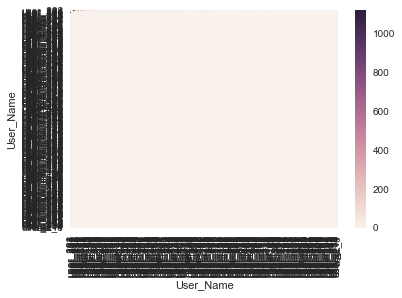

In [369]:
# Example from here: https://seaborn.pydata.org/generated/seaborn.heatmap.html
ax = sns.heatmap(heatmap_df)

plt.show()

In [370]:
# "Save" `df`, because we're going to make some modifications below
orig = df.copy(deep=True)

### Let's first take a look at the top *n* volunteers and how well they agree with each other.
Some volunteers have viewed the same image multiple times. For the sake of simplicity, each volunteer's "answer" for each image they've seen will be their most recent classification. This isn't a bad assumption, as I would venture to say volunteers have improved throughout their time classifying deeds.

In [373]:
df = orig.copy(deep=True)

df.sort_values('Class_Date', ascending=False, inplace=True)

# filter to just look at the top n volunteers
df = df[df['User_Name'].isin(top_n_volunteers)]

df.drop_duplicates(subset=['User_Name', 'Image_ID'], inplace=True)

Now look at overlap *and agreement* between these volunteers... This is what we came here for...

In [ ]:
overlap = []

for user, user_df in df.groupby('User_Name'):
    # Images the main user has seen and associated ratings    
    user_img_seen = {user_df.loc[idx, 'Image_ID']: user_df.loc[idx, 'Match']
                         for idx in user_df.index}
    
    for other_user, other_df in df[df['User_Name'] != user].groupby('User_Name'):
        # Images the other user has seen and associated ratings
        other_user_img_seen = {other_df.loc[idx, 'Image_ID']: other_df.loc[idx, 'Match']
                                 for idx in other_df.index}
        
        # Set intersection between what the user's seen and what the other user has seen
        common = set(user_img_seen) & set(other_user_img_seen)

        # We only care to measure agreement between raters who have seen the same deeds
        if common:
            # Pairs of answers for each deed (image) commonly seen
            together = [(user_img_seen[img], other_user_img_seen[img])
                            for img in common]

            # Used to calculate Cohen's Kappa
            user_vector = [x[0] for x in together]
            other_user_vector = [x[1] for x in together]

            # Can use sklearn.metrics.cohen_kappa_score, but should go through exercise of actually calculating...
            # http://psych.unl.edu/psycrs/handcomp/hckappa.PDF
            
            # If cohen_kappa_score returns np.nan, then we know each user agreed 100%...
            # but there was no "random chance" component
            
            # https://github.com/scikit-learn/scikit-learn/issues/9624
            # "1 in Cohen's Kappa indicates perfect agreement with 0 chance of agreement at random.
            # Here there is perfect agreement at random."
            cohen_kappa = cohen_kappa_score(user_vector, other_user_vector)
            
            if not np.isnan(cohen_kappa):
                # Set of IDs agreed- and disagreed-upon
                agreements = {img for img in common if user_img_seen[img] == other_user_img_seen[img]}
                disagreements = {img for img in common if user_img_seen[img] != other_user_img_seen[img]}

                n_common = len(common)
                n_agreements = len(agreements)
                n_disagreements = len(disagreements)

                # Keep track of classifications in common and the number of in-common classifications (images seen)
                overlap.append(
                    {'user': user,
                    'other_user': other_user,
                    'cohen_kappa': cohen_kappa,
                    'n_in_common': n_common,

                    # The following are relatively more naive measures of reliability... just the percentages of 
                    # agreement/disagreement
                    'n_agreements': n_agreements,
                    'n_disagreements': n_disagreements,
                    'perc_agreements': handle_zero_division(n_agreements, n_common),
                    'perc_disagreements': handle_zero_division(n_disagreements, n_common),
                    'agree_disagree_ratio': handle_zero_division(n_agreements, n_disagreements),
                    'user_together_drop_dupe': frozenset((user, other_user))
                    }
                )

agreement_df = (pd.DataFrame
                .from_records(overlap)
                .drop_duplicates(subset=['user_together_drop_dupe']))

/Users/jake/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:350: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


In [356]:
print(other_df)

           Retired User_Name  Class_ID Class_Date Match             Image_ID  \
22327      Retired  user_210  70064859 2017-09-12   NaN  1056_0304_match.jpg   
22328  Not Retired  user_210  70064869 2017-09-12   NaN  1147_0524_match.jpg   
22329  Not Retired  user_210  70064957 2017-09-12   NaN  1150_0158_match.jpg   
22330  Not Retired  user_210  70064963 2017-09-12   NaN  1184_0477_match.jpg   
22331      Retired  user_210  70064971 2017-09-12   NaN  1240_0236_match.jpg   
22324  Not Retired  user_210  70064687 2017-09-12   NaN   783_0308_match.jpg   
22325  Not Retired  user_210  70064704 2017-09-12   NaN  1141_0455_match.jpg   

      Racial_Res  City Addition  Lot Block Doc_ID Grantor Grantee  \
22327        NaN   NaN      NaN  NaN   NaN    NaN     NaN     NaN   
22328        NaN   NaN      NaN  NaN   NaN    NaN     NaN     NaN   
22329        NaN   NaN      NaN  NaN   NaN    NaN     NaN     NaN   
22330        NaN   NaN      NaN  NaN   NaN    NaN     NaN     NaN   
22331        N

In [338]:
print(agreement_df.sort_values(['n_in_common', 'cohen_kappa'], ascending=False).head())

     agree_disagree_ratio  cohen_kappa  n_agreements  n_disagreements  \
228             12.023256     0.868319          1034               86   
87              20.687500     0.920297           993               48   
142             41.923077     0.958473           545               13   
226             20.000000     0.918431           520               26   
224              3.986842     0.658259           303               76   

     n_in_common other_user  perc_agreements  perc_disagreements      user  \
228         1120   user_332         0.923214            0.076786  user_223   
87          1041   user_223         0.953890            0.046110  user_139   
142          558   user_223         0.976703            0.023297  user_161   
226          546   user_305         0.952381            0.047619  user_223   
224          379   user_257         0.799472            0.200528  user_223   

    user_together_drop_dupe  
228    (user_332, user_223)  
87     (user_139, user_223)  
14

In [348]:
# Found a troll: uo1554pf, or user_1
(agreement_df
 .groupby('user')[['cohen_kappa', 'n_in_common']]
 .agg({'cohen_kappa': np.mean, 'n_in_common': np.sum})
 .sort_values(by=['cohen_kappa', 'n_in_common'], ascending=False)
 .tail(10))

,cohen_kappa,n_in_common
user,,
user_333,0.0,4
user_460,0.0,4
user_404,0.0,2
user_283,0.0,1
user_345,0.0,1
user_361,0.0,1
user_386,0.0,1
user_426,0.0,1
user_529,0.0,1


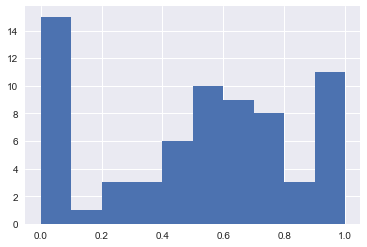

In [349]:
agreement_df.groupby('user')['cohen_kappa'].mean().hist()

In [351]:
agb = agreement_df.groupby('user')['cohen_kappa'].mean()
agb[(agb <= 0.4) & (agb > 0)].shape

(11,)

What follows is an attempt to obtain for each rater their "reliability" score, which should be some combination of their average or median Cohen's Kappa value and how many classifications they've done...

In [215]:
avg_kappa = agreement_df.groupby(['user'])['cohen_kappa'].mean()

num_clfs = df.groupby(['User_Name']).size().to_frame('n_clfs')

reliability_df = pd.concat((avg_kappa, num_clfs), axis=1).head(10)

# Not a good measure below... needs to be normalized big-time
# reliability_df['reliability_score'] = reliability_df['cohen_kappa'] * reliability_df['n_clfs']

#print(reliability_df.sort_values('reliability_score', ascending=False).head(10))
print(reliability_df.sort_values(['cohen_kappa', 'n_clfs'][::-1], ascending=False).head(10))

# Slight positive correlation between Cohen's Kappa (one of our IRR measures) and number of classifications... sig?
print(reliability_df.corr())

               cohen_kappa  n_clfs
Zoocitizen        0.791973    1041
MaryEverest       0.712757     360
Arscott           0.743245     204
SteveBrandt       0.714554     179
Shepsdaughter     0.748574     106
TomArctus         0.884328      86
LydiaMcComas      0.776611      82
Lindell           0.394917      69
AsherMA           0.357713      69
HulkW             0.984164      41
             cohen_kappa    n_clfs
cohen_kappa     1.000000  0.153796
n_clfs          0.153796  1.000000


In [226]:
agreement_df[agreement_df['user'] == 'neuhausr'].sort_values('n_in_common', ascending=False).head(10)

,agree_disagree_ratio,cohen_kappa,n_agreements,n_disagreements,n_in_common,other_user,perc_agreements,perc_disagreements,user,user_together_drop_dupe
1701,21.777778,0.917302,196,9,205,pennypetersen,0.956098,0.043902,neuhausr,"(pennypetersen, neuhausr)"
1702,1.000000,0.000000,1,1,2,pjwollum,0.500000,0.500000,neuhausr,"(pjwollum, neuhausr)"
1703,NaN,NaN,2,0,2,qq7918wn,1.000000,0.000000,neuhausr,"(qq7918wn, neuhausr)"
1705,NaN,1.000000,2,0,2,russtrebor,1.000000,0.000000,neuhausr,"(russtrebor, neuhausr)"
1714,NaN,NaN,2,0,2,xydata,1.000000,0.000000,neuhausr,"(xydata, neuhausr)"
1706,NaN,NaN,1,0,1,sam.burrill-bowen,1.000000,0.000000,neuhausr,"(sam.burrill-bowen, neuhausr)"
1708,NaN,NaN,1,0,1,slugs,1.000000,0.000000,neuhausr,"(slugs, neuhausr)"
1709,NaN,NaN,1,0,1,sophiekmongo,1.000000,0.000000,neuhausr,"(sophiekmongo, neuhausr)"
1711,NaN,NaN,1,0,1,tlogeland,1.000000,0.000000,neuhausr,"(tlogeland, neuhausr)"
1712,0.000000,0.000000,0,1,1,uo1554pf,0.000000,1.000000,neuhausr,"(uo1554pf, neuhausr)"


### Next, we should probably start to take this approach (using Cohen's Kappa and the number of classifications -- some "score" developed out of those two KPIs) and enable Kevin to use the score to automatically take the classification given by the more reliable rater... After all, that's what he wanted -- 1) a way to better assess which raters might need more training and 2) to improve the accuracy of their retirement process by "taking the word" of the more reliable raters...

In [225]:
#http://psych.unl.edu/psycrs/handcomp/hckappa.PDF
import random
random.seed(100)

a = [random.choice(['yes', 'no', 'maybe']) for _ in range(25)]
b = [random.choice(['yes', 'no', 'maybe']) for _ in range(25)]

unique_vals = set(a) | set(b)

contin_tb = pd.DataFrame(data=np.zeros((len(unique_vals), len(unique_vals))),
                         index=unique_vals,
                         columns=unique_vals)

for rater_a_obs, rater_b_obs in zip(a, b):
    contin_tb.loc[rater_a_obs, rater_b_obs] += 1
    
print(contin_tb); print()

row_total = contin_tb.sum(axis=0)
column_total = contin_tb.sum(axis=1)

overall_total = (row_total + column_total).sum()

print(row_total, '\n'*2, column_total)

# Sum along diagonal... total number of agreements
agreements = np.trace(contin_tb)

# Expected frequencies for the number of agreements that would've occurred by change
exp_freq = (row_total * column_total)/overall_total

# Sum of expected frequencies that would occur by chance
exp_freq_sum = exp_freq.sum()

# Compute Kappa
kappa = (agreements - exp_freq_sum)/(overall_total - exp_freq_sum)

       yes   no  maybe
yes    4.0  3.0    2.0
no     6.0  1.0    2.0
maybe  1.0  4.0    2.0

yes      11.0
no        8.0
maybe     6.0
dtype: float64 

 yes      9.0
no       9.0
maybe    7.0
dtype: float64


In [ ]:
############ What follows is just a bunch of extra stuff ..... Not immediately necessary for IRR exam from above

In [93]:
# Images that have been seen quite a bit... would be interesting to investigate how many of these were actually retired
# or how many views it takes to retire an image
df.groupby(['Image_ID']).size().sort_values(ascending=False).head(20)

Image_ID
970_0334_match.jpg     6
969_0180_match.jpg     6
1446_0014_match.jpg    6
1054_0599_match.jpg    5
967_0224_match.jpg     5
1190_0394_match.jpg    5
1423_0523_match.jpg    5
1097_0145_match.jpg    5
1126_0315_match.jpg    5
969_0598_match.jpg     5
1043_0465_match.jpg    5
1126_0195_match.jpg    5
1623_0072_match.jpg    5
783_0324_match.jpg     5
1054_0133_match.jpg    5
818_0161_match.jpg     5
970_0042_match.jpg     5
1118_0415_match.jpg    5
1046_0181_match.jpg    5
760_0115_match.jpg     4
dtype: int64

In [72]:
print('Are there any users that have seen the same image more than once? {}'
      .format((df.groupby(['User_Name', 'Image_ID']).size() > 1).any()))

df.groupby(['User_Name', 'Image_ID', 'Match']).size().sort_values(ascending=False).head(50)

Are there any users that have seen the same image more than once? True


User_Name      Image_ID             Match                       
pennypetersen  1134_0274_match.jpg  No                              4
               1423_0523_match.jpg  Yes                             3
               1123_0597_match.jpg  Yes                             3
               1190_0394_match.jpg  I can't figure this one out.    3
               1036_0027_match.jpg  Yes                             3
               1446_0014_match.jpg  Yes                             3
               1304_0227_match.jpg  No                              3
               1623_0072_match.jpg  No                              3
               1570_0333_match.jpg  No                              2
               1052_0243_match.jpg  No                              2
mspl           728_0585_match.jpg   No                              2
pennypetersen  1244_0026_match.jpg  Yes                             2
mspl           725_0347_match.jpg   No                              2
pennypetersen  1417_0486_

Interesting. Some users have seen the same images several times. Below, Penny saw the same image four times and never once retired it! That's a resounding "no" if I ever saw one.

In [95]:
df[(df['User_Name'] == 'pennypetersen') & (df['Image_ID'] == '1134_0274_match.jpg')]

,Retired,User_Name,Class_ID,Class_Date,Match,Image_ID,Racial_Res,City,Addition,Lot,Block,Doc_ID,Grantor,Grantee,Date_Deed,Date_Ex
4426,Not Retired,pennypetersen,49436700,2017-04-18,No,1134_0274_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
4433,Not Retired,pennypetersen,49439070,2017-04-18,No,1134_0274_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
6321,Not Retired,pennypetersen,52478991,2017-05-04,No,1134_0274_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
10257,Not Retired,pennypetersen,58099394,2017-06-03,No,1134_0274_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null


Index(['Retired', 'User_Name', 'Class_ID', 'Class_Date', 'Match', 'Image_ID',
       'Racial_Res', 'City', 'Addition', 'Lot', 'Block', 'Doc_ID', 'Grantor',
       'Grantee', 'Date_Deed', 'Date_Ex'],
      dtype='object')


User_Name      Image_ID           
pennypetersen  1134_0274_match.jpg    4
               1446_0014_match.jpg    4
               1190_0394_match.jpg    3
               1036_0027_match.jpg    3
               1304_0227_match.jpg    3
LydiaMcComas   969_0598_match.jpg     3
pennypetersen  1423_0523_match.jpg    3
               1123_0597_match.jpg    3
               1623_0072_match.jpg    3
lienadams      1488_0274_match.jpg    2
mspl           801_0124_match.jpg     2
pennypetersen  1045_0606_match.jpg    2
               1486_0584_match.jpg    2
               1244_0026_match.jpg    2
mspl           725_0347_match.jpg     2
pennypetersen  1450_0092_match.jpg    2
AsherMA        970_0334_match.jpg     2
mspl           728_0585_match.jpg     2
pennypetersen  1051_0458_match.jpg    2
mspl           731_0372_match.jpg     2
dtype: int64

In [63]:
df.groupby(['Image_ID', 'Match']).size().sort_index().head(40)

Image_ID             Match                       
1028_0012_match.jpg  Yes                             2
1028_0019_match.jpg  Yes                             1
1028_0062_match.jpg  I can't figure this one out.    2
1028_0070_match.jpg  No                              3
1028_0082_match.jpg  Yes                             3
1028_0101_match.jpg  I can't figure this one out.    1
                     No                              2
1028_0106_match.jpg  No                              1
1028_0122_match.jpg  No                              1
1028_0124_match.jpg  No                              3
1028_0146_match.jpg  No                              1
                     Yes                             1
1028_0155_match.jpg  Yes                             3
1028_0165_match.jpg  Yes                             3
1028_0196_match.jpg  Yes                             1
1028_0199_match.jpg  I can't figure this one out.    1
                     Yes                             1
1028_0203_match

In [61]:
df[df['Image_ID'] == '1029_0468_match.jpg']

,Retired,User_Name,Class_ID,Class_Date,Match,Image_ID,Racial_Res,City,Addition,Lot,Block,Doc_ID,Grantor,Grantee,Date_Deed,Date_Ex
2401,Retired,MaryEverest,35339996,2017-03-22,No,1029_0468_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
4645,Retired,pennypetersen,49703169,2017-04-19,No,1029_0468_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
23844,Retired,Zoocitizen,71703700,2017-09-25,No,1029_0468_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
25131,Retired,kayrakaye,72702090,2017-10-03,No,1029_0468_match.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,null-null-null,null-null-null
